In [ ]:
# import libraries
from torch import nn as nn
import torch
import torch.autograd
import numpy as np
import matplotlib.pyplot as plt

#Solving System of ODEs

$x_{1}' = 3x_{1} - 3x_{2} +2$





$x_1(0) = 1$

$x_{2}' = -6x_{1} - t$

$x_{2}(0) = -1$

#Solution

$x_{1}(t) = \frac{1}{108}(133e^{6t}-28e^{-3t}-18t+3) $

$x_{2}(t) = -\frac{1}{108}(133e^{6t}+56e^{-3t}+18t-81) $

# Setup NN to estimate value of dependent variable

In [ ]:
class UNN(nn.Module):
    def __init__(self, input_size = 1, output_size = 2, hidden_layers = 5, hidden_nodes = 10):
        super().__init__()
        self.input_layer  = nn.Linear(input_size, hidden_nodes) # first layer: input to hidden size: ie 1 to 10
        self.hidden_layers_list = nn.ModuleList([nn.Linear(hidden_nodes, hidden_nodes)] * hidden_layers) # hidden layers: 10 to 10
        self.output_layer = nn.Linear(hidden_nodes, output_size) # hidden to output layer: 10 to 1 (prediction)
        self.activation_function = nn.Tanh() # Construct activation fxn

    def forward(self, t):
        t = self.activation_function(self.input_layer(t)) #Input to first hidden layer
        for hidden_layer in self.hidden_layers_list:  #Passes the previous layer input through a hidden layer, followed by an activation, repeating for all hidden layers
            t = self.activation_function(hidden_layer(t))
        t = self.output_layer(t) # last hidden layer to output, no activations applied as this is the prediction
        return t

# Data and pre-processing

In [ ]:
#Dataset
t = np.linspace(0,2,1000) # domain of 0 to 2 s, take 1000 collocation points evenly
x_1 = (133*np.exp(6*t)-28*np.exp(-3*t)-18*t+3)/108
x_2 = -(133*np.exp(6*t)+56*np.exp(-3*t)+18*t-81)/108

In [ ]:
import pandas as pd
data = {'t': np.ravel(t), 'x_1': np.ravel(x_1), 'x_2': np.ravel(x_2)}
df = pd.DataFrame(data)

In [ ]:
df.head(10)

,t,x_1,x_2
0,0.000000,1.000000,-1.000000
1,0.002002,1.016101,-1.012111
2,0.004004,1.032372,-1.024420
3,0.006006,1.048816,-1.036929
4,0.008008,1.065434,-1.049641
5,0.010010,1.082231,-1.062558
6,0.012012,1.099206,-1.075681
7,0.014014,1.116364,-1.089014
8,0.016016,1.133706,-1.102558
9,0.018018,1.151235,-1.116315


In [ ]:
# prepare data as tensor for processing with neural network
t = t.reshape(-1,1)
t_data = t[0:400:40] # use 40% of total range as training data, take 10 points evenly from range
t_train = torch.tensor(t_data, dtype=torch.float32, device="cpu") #convert to torch tensor

x_1 = x_1.reshape(-1,1)
x_1_data = x_1[0:400:40] # use 40% of total range as training data
x_1_train = torch.tensor(x_1_data, dtype=torch.float32, device="cpu")
t = t.reshape(-1,1)
t_data = t[0:400:40] # use 40% of total range as training data, take 10 points evenly from range
t_train = torch.tensor(t_data, dtype=torch.float32, device="cpu") #convert to torch tensor
x_2 = x_2.reshape(-1,1)
x_2_data = x_2[0:400:40] # use 40% of total range as training data
x_2_train = torch.tensor(x_2_data, dtype=torch.float32, device="cpu")
x_train = torch.cat((x_1_train,x_2_train), 1)
# points for prediction for ODE loss eval
t_physics = torch.linspace(0, 2, 20, requires_grad=True, device="cpu", dtype=torch.float32).reshape(-1,1)

# Initialize and Optimize PINN

In [ ]:
pinn = UNN()
optim = torch.optim.Adam(pinn.parameters(), lr=0.0001)
mse_loss = nn.MSELoss()

In [ ]:
x_ode = pinn(t_physics)

In [ ]:
x_1_nn, x_2_nn = torch.split(x_ode.t(),1)
x_1_nn = x_1_nn.t()
x_2_nn = x_2_nn.t()

In [ ]:
dx_1 = torch.autograd.grad(x_1_nn.sum(), t_physics, create_graph=True)[0]

In [ ]:
epochs = 20000
for epoch in range(epochs):
    optim.zero_grad() #zeros out all the gradients (by default torch accumulates gradients)

    # use NN to predict output purely from data, (limited range training data above):
    x_nn = pinn(t_train)
    data_loss = mse_loss(x_nn, x_train)

    # use NN to predict output over entire domain of interest, based on reconstructing ODE
    x_ode = pinn(t_physics)
    x_1_nn, x_2_nn = torch.split(x_ode.t(),1)
    x_1_nn = x_1_nn.t()
    x_2_nn = x_2_nn.t()
    dx_1 = torch.autograd.grad(x_1_nn, t_physics, torch.ones_like(x_1_nn), create_graph=True)[0]
    dx_2 = torch.autograd.grad(x_2_nn, t_physics, torch.ones_like(x_2_nn), create_graph=True)[0]
    ode_loss_1 = dx_1 - 3*x_1_nn + 3*x_2_nn - 2 + dx_2 + 6*x_1_nn + t_physics


    physics_loss_1 = torch.mean(ode_loss_1**2)

    # in this case, real data is known, bypassing the need for a boundary condition loss, but could be added
    # real data determines the exact solution ODE in conjunction with regularization term "physics_loss"

    loss = data_loss + physics_loss_1  # hybrid physics informed and data driven loss
    loss.backward() # gradient descent
    optim.step()
    if epoch % 1000 == 0:
        print(f"Epochs = {epoch} of {epochs}, Loss = {float(loss):.7f}")

Epochs = 0 of 20000, Loss = 1381.9373779
Epochs = 1000 of 20000, Loss = 1324.0670166
Epochs = 2000 of 20000, Loss = 1250.7501221
Epochs = 3000 of 20000, Loss = 1200.2811279
Epochs = 4000 of 20000, Loss = 1157.7493896
Epochs = 5000 of 20000, Loss = 1119.2738037
Epochs = 6000 of 20000, Loss = 1083.7689209
Epochs = 7000 of 20000, Loss = 1050.8287354
Epochs = 8000 of 20000, Loss = 1020.2775269
Epochs = 9000 of 20000, Loss = 992.0286255
Epochs = 10000 of 20000, Loss = 966.0322266
Epochs = 11000 of 20000, Loss = 942.2562866
Epochs = 12000 of 20000, Loss = 920.6725464
Epochs = 13000 of 20000, Loss = 901.2553711
Epochs = 14000 of 20000, Loss = 883.9761963
Epochs = 15000 of 20000, Loss = 868.8027344
Epochs = 16000 of 20000, Loss = 855.6974487
Epochs = 17000 of 20000, Loss = 844.6134644
Epochs = 18000 of 20000, Loss = 835.4917603
Epochs = 19000 of 20000, Loss = 828.2559204


In [ ]:
pinn.eval()
u_nn = pinn(torch.tensor(t, dtype = torch.float32, device="cpu").reshape(-1,1))
x_1_out, x_2_out = torch.split(u_nn.t(),1)
x_1_out = x_1_out.t().detach().cpu().numpy()
x_2_out = x_2_out.t().detach().cpu().numpy()

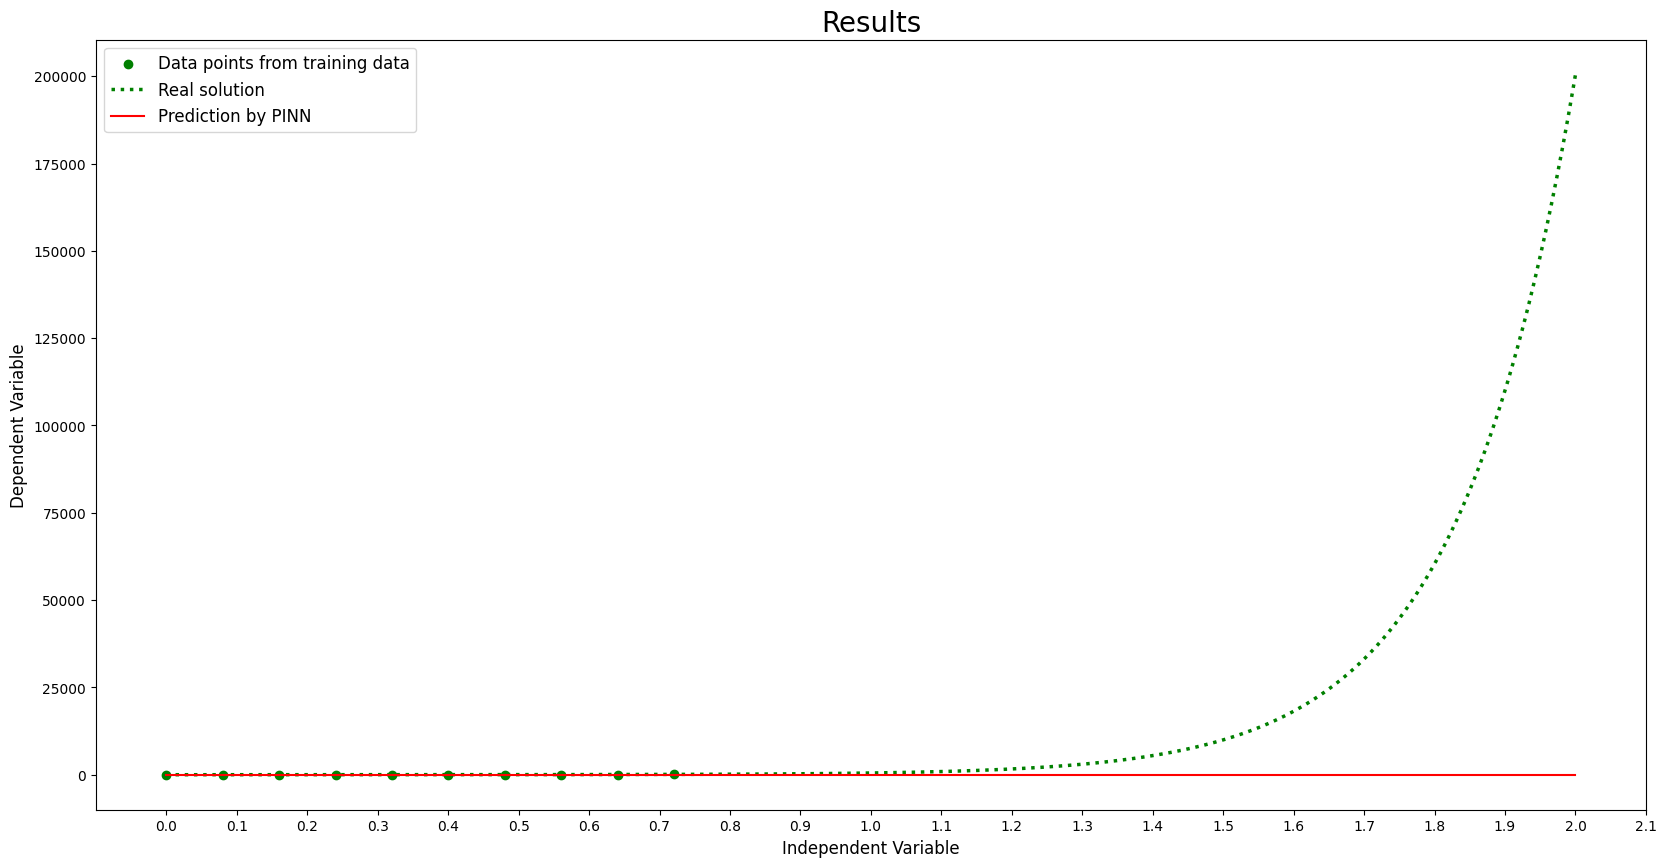

In [ ]:
plt.figure(figsize=(20, 10))
plt.xticks(np.arange(0, 2.5, step=0.1))
plt.title("Results", fontsize=20)
plt.xlabel("Independent Variable", fontsize=12)
plt.ylabel("Dependent Variable", fontsize=12)

plt.scatter(t_data.reshape(-1,), x_1_data.reshape(-1,), c="g", label="Data points from training data")
plt.plot(t, x_1, label="Real solution", linewidth=2.5, linestyle='dotted', c='g')
plt.plot(t, x_1_out, label="Prediction by PINN", c="r")


plt.legend(fontsize="large")
plt.show()

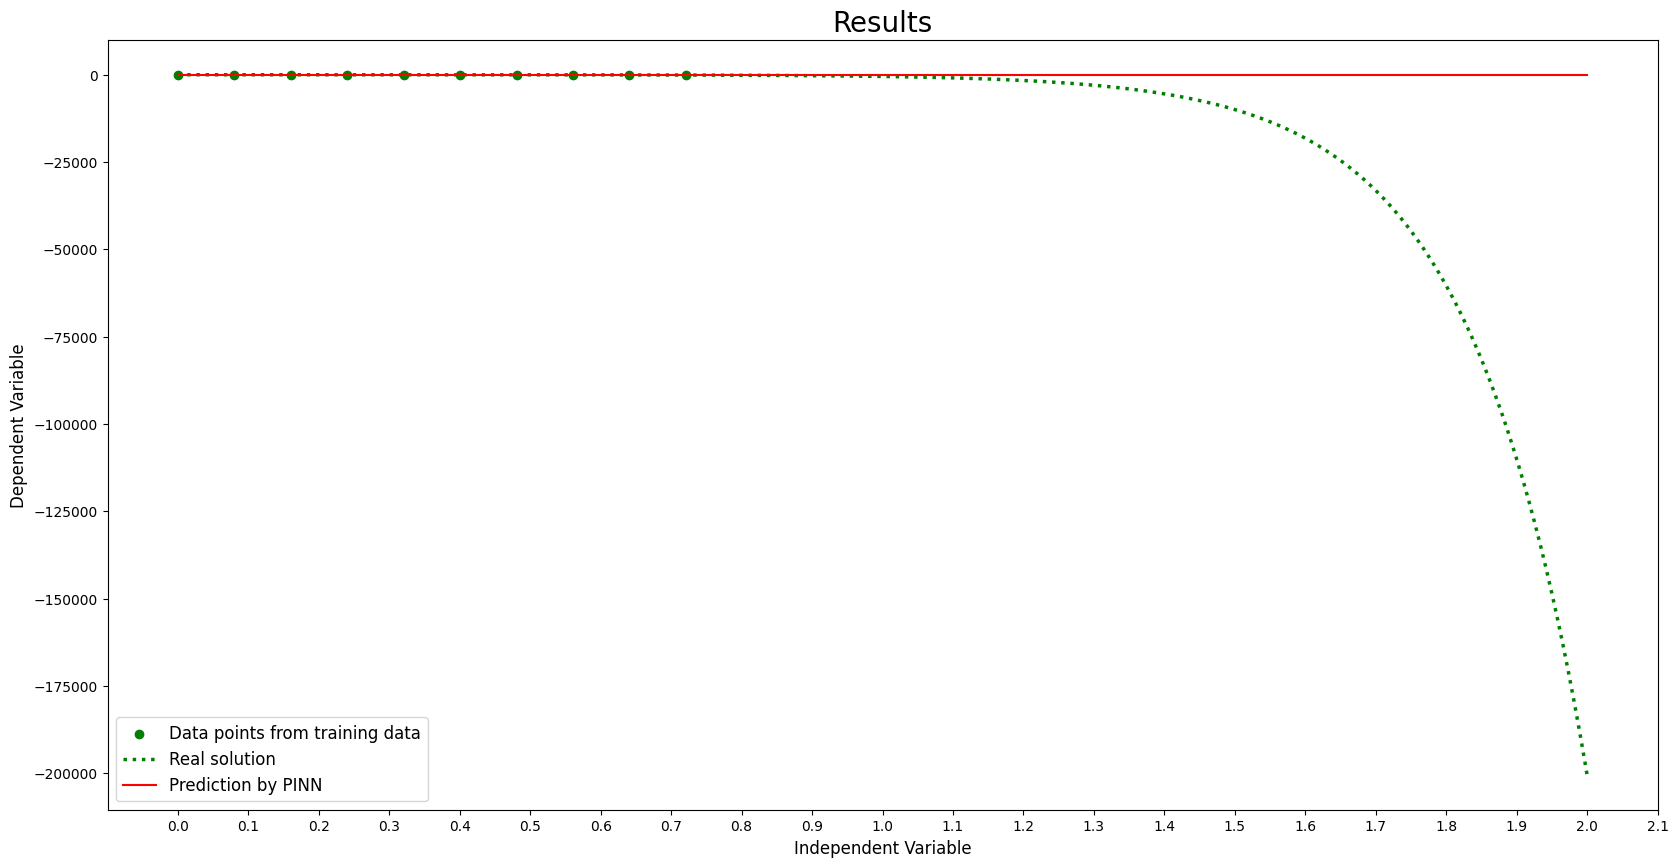

In [ ]:
plt.figure(figsize=(20, 10))
plt.xticks(np.arange(0, 2.5, step=0.1))
plt.title("Results", fontsize=20)
plt.xlabel("Independent Variable", fontsize=12)
plt.ylabel("Dependent Variable", fontsize=12)

plt.scatter(t_data.reshape(-1,), x_2_data.reshape(-1,), c="g", label="Data points from training data")
plt.plot(t, x_2, label="Real solution", linewidth=2.5, linestyle='dotted', c='g')
plt.plot(t, x_2_out, label="Prediction by PINN", c="r")


plt.legend(fontsize="large")
plt.show()